In [29]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import imshow

<h3> Load the Dataset </h3>

In [2]:
ls

Assignmet_2.docx                      Modelling_Knn.ipynb
Dummy estimators.ipynb                Modelling_SVM-Copy1.ipynb
EDA.ipynb                             Modelling_SVM.ipynb
EDA_V2_Kaggle.ipynb                   XGBOOST.ipynb
Exercise 2.pdf                        digit_recognizer_dataset.csv*
Feature Selection.ipynb               digit_recognizer_dataset_reduced.csv
Icon?                                 ~$signmet_2.docx
Modelling_Decision_Trees.ipynb


In [27]:
data = pd.read_csv("digit_recognizer_dataset_reduced.csv")

In [28]:
# Print the first 5 records of the dataset
data.head()

,label,pixel12,pixel13,pixel14,pixel15,pixel32,pixel33,pixel34,pixel35,pixel36,...,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Standardise Data - Features are already at the same scale...0-255

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(X)
# rescaled_data = scaler.transform(data[features])
# # summarise transformed data
# set_printoptions(precision=3)
# print(rescaledX[0:5,:])

<h3> Search for the optimum number of Principal Components </h3>

In [30]:
from numpy import mean
from numpy import std

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from matplotlib import pyplot
from sklearn.svm import SVC

In [31]:
# Create a list of models to experiment with
# We will create 20 models. Each model will take as input a different number of principal components.
# (i.e., only one component as input, two components, three,...,twenty)
def get_models():
    models = dict()
    for i in range(1,15):
        # This way we essentially define a two-step process:
        # Perform PCA and use the output of PCA as input to logistic regrassion
        steps = [('pca', PCA(n_components=i)), ('m', SVC())]
        models[str(i)] = Pipeline(steps=steps)
    return models

In [32]:
# Evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [33]:
# Seperate the dataset into Features and Labels
y_labels =data['label'].values       # Target values - numpy.ndarray
X_features = data.drop(['label'],axis=1).values

>1 0.309 (0.002)
>2 0.468 (0.002)
>3 0.533 (0.002)
>4 0.659 (0.002)
>5 0.759 (0.003)
>6 0.837 (0.002)
>7 0.879 (0.003)
>8 0.903 (0.003)
>9 0.915 (0.002)
>10 0.930 (0.001)
>11 0.937 (0.001)
>12 0.946 (0.001)
>13 0.952 (0.001)
>14 0.958 (0.001)


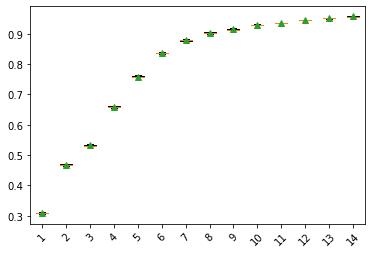

In [34]:
# Get the models
models = get_models()

# Evaluate the models and store results
results = []
names = []
for name, model in models.items():
    scores = evaluate_model(model, X_features, y_labels)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    
# Plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

More than 15 principal components do not contribute significatly 

<h3> Apply PCA Transformation with 15 Components </h3>

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15, whiten=True)
X_pca = pca.fit_transform(X_features)

print(pca.explained_variance_ratio_)

[0.09748938 0.07160266 0.06145903 0.05379302 0.04894262 0.04303214
 0.03277051 0.02892103 0.02766902 0.02348871 0.02099323 0.02058998
 0.01702541 0.01692753 0.0158106 ]


<h3> Search for The best Kernel Using Cross Validation </h3>

--> Building model for linear kernel
: Accuracy scores [0.87435714 0.87464286 0.87864286]
--> Building model for poly kernel
: Accuracy scores [0.95442857 0.95285714 0.95457143]
--> Building model for rbf kernel
: Accuracy scores [0.96157143 0.95778571 0.96107143]
--> Building model for sigmoid kernel
: Accuracy scores [0.67114286 0.67735714 0.66692857]


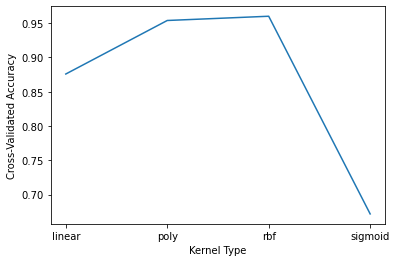

In [36]:
import gc

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

import matplotlib.pyplot as plt 
%matplotlib inline

kernels = ["linear", "poly", "rbf", "sigmoid"]
scores = []


for kernel in kernels:
    print("--> Building model for {} kernel".format(kernel))
    model = make_pipeline(StandardScaler(), SVC(kernel=kernel, random_state=2020))
    model_scores = cross_val_score(model, X_pca, y_labels, cv=3, n_jobs=-1, scoring='accuracy')
    print(": Accuracy scores {}".format(model_scores))
    scores.append(model_scores.mean())
    del model
    gc.collect()

plt.plot(kernels, scores)
plt.xlabel('Kernel Type')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

<em><i> The RBF Kernel Achieves the best Cross-Validated Accuracy </i></em>

<h2> Search for the Best Hyper-parameters Using the Random Search Method </h2>

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import scipy

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

import matplotlib.pyplot as plt 
%matplotlib inline

distributions = {'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1),
  'kernel': ['rbf'], 'class_weight':['balanced', None]}

# distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])

clf = RandomizedSearchCV(SVC(), distributions, random_state=0)

search = clf.fit(X_pca, y_labels)

search.best_params_

<h2> Train and Evaluate a SVM Learner using the previously determined optimum parameters </h2>

In [19]:
# 3-Fold Cross Validation
from sklearn.svm import SVC

model = SVC(C=315.0170036823506, kernel='rbf', degree=3, gamma=0.2040314280945551, coef0=0.0, 
            shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None)

# model.fit(X, y)
model_scores = cross_val_score(model, X_pca, y_labels, cv=3, n_jobs=-1, scoring='accuracy')

print(": Accuracy scores {}".format(model_scores))

: Accuracy scores [0.96578571 0.96314286 0.96542857]


<h2> Train and Evaluate using Random Split </h2>

In [22]:
from sklearn.model_selection import train_test_split

#
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_labels, test_size=0.33, random_state=42)

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

model = SVC(C=315.0170036823506, kernel='rbf', degree=3, gamma=0.2040314280945551, coef0=0.0, 
            shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
conf_matrix = confusion_matrix(y_test,predictions)

print(f"The accuracy achieved is : {accuracy_score(y_test, predictions)}\n")
print("        The Confusion Matrix\n")
print(conf_matrix)

The accuracy achieved is : 0.9647907647907648

        The Confusion Matrix

[[1319    0    4    2    1    0    4    0    1    2]
 [   0 1507    4    2    3    1    2    0    0    1]
 [   6    7 1362    6    5    1    2   16    7    2]
 [   3    4   13 1391    0   16    1    4   34    5]
 [   2    0    6    0 1298    0    3    3    2   44]
 [   2    2    2   30    1 1137   10    0   10   11]
 [   5    2    3    1    5    5 1368    0    8    0]
 [   0    4   12    2    5    0    0 1429    3   25]
 [   1    3    3   16    4    9    4    2 1288    4]
 [   8    4    3   13   15    8    1   21    2 1273]]




<em> From the previous plotted confusion matrix we can conclude that 
the algorithm tends to misclassify the number 4 with the number 9
and the number 3 with the number 8. Furthermore, the number 5 is misinterpret as the number 3 </em>

<h3> Evaluation Metrics Precision - Recall - F1_Score </h3>

In [13]:
from sklearn.metrics import precision_score
precision = precision_score(y_test, predictions, average='macro') # precision_score(y_true, y_pred, average='macro')

print('Macro precision score: {0:0.2f}'.format(
      precision))

Macro precision score: 0.97


In [16]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, predictions, average='macro') 

print('Macro recall score: {0:0.2f}'.format(
      recall))

Macro recall score: 0.97


In [17]:
from sklearn.metrics import f1_score
f1_s = f1_score(y_test, predictions, average='macro')

print('Macro f1 score: {0:0.2f}'.format(
      f1_s))
                                           

Macro f1 score: 0.97
